In [12]:
from tqdm import tqdm
import torch
import numpy as np
import torch
import torch.nn as nn
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 0.0 Hyper Parameters

In [13]:
root_dir_datasetC = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
root_dir_datasetS = '/kaggle/input/best-artworks-of-all-time/images/images'
# WEIGHTS
ENCODER_PATH = '/kaggle/input/style-transfer-project-data/vgg_r41.pth'
DECODER_PATH = '/kaggle/input/style-transfer-project-data/dec_r41.pth'

# Trained Model Path
MODEL_WEIGHTS_PATH = ''

image_size = 128
batch_size = 16 
train_ratio = 0.9

num_epochs = 120
step_size = 10
eval_freq = 1
gamma = 0.1  
learning_rate = 0.0001

STYLE_WEIGHT = 0.02
CONTENT_WEIGHT = 1.0


**Util Funtions**

In [14]:
def get(a):
    return next(iter(a))

In [15]:
# set random seed
def set_random_seeds(seed=42):
    # Set random seed for PyTorch on CPU
    torch.manual_seed(seed)

    # Set random seed for PyTorch on GPU, if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Set random seed for NumPy
    np.random.seed(seed)

# Call this function at the beginning of your script or notebook
set_random_seeds()

In [16]:
mean_, std_ = [0.0, 0.0, 0.0], [1.0,1.0, 1.0]
denormalize_transform = transforms.Normalize(
mean=[-m/s for m, s in zip(mean_, std_)],std=[1/s for s in std_])

# 1.0 Prepare datasets
1. **Content dataset** : Used 'COCO 2017 Dataset' having variaty of images.
2.  **Style dataset** : Used 'Best Artworks of All Time' artworks of the 50 most influential artists of all time.

**Kaggle Dataset link**:
1. **Content dataset** : https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset
2.  **Style dataset** : https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/

**Util Funtions**

In [17]:
def display_random_images(dataset, num_images=1):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        # Get a random index
        index = np.random.randint(len(dataset))
        
        # Get the image pair
        img1, img2 = dataset[index]
#         img1 = denormalize_transform(img1)
#         img2 = denormalize_transform(img2)

        # Display the images
        axes[0, i].imshow(np.transpose(img1.numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Content Image {i+1}')

        axes[1, i].imshow(np.transpose(img2.numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Style Image {i+1}')

    plt.show()



In [58]:
def to_cpu(tensor):
    """Move a PyTorch tensor to CPU."""
    return tensor.detach().cpu()

def display_translated_images(content_images, style_images, transferred_images, num_images=1):
    B, C, H, W = content_images.shape

    # Ensure the number of requested images is not greater than the batch size
    num_images = min(num_images, B)

    # Create a grid for displaying images
    fig, axes = plt.subplots(3, num_images, figsize=(15, 9))

    for i in range(num_images):
        # Move images to CPU if they are on GPU
        content_img = to_cpu(content_images[i])
        style_img = to_cpu(style_images[i])
        transferred_img = to_cpu(transferred_images[i])
        
#         content_img = denormalize_transform(content_img)
#         style_img = denormalize_transform(style_img)
#         transferred_img = denormalize_transform(transferred_img)

        
        # Display content image
        axes[0, i].imshow(np.transpose(content_img.numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title('Content Image')

        # Display style image
        axes[1, i].imshow(np.transpose(style_img.numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title('Style Image')

        # Display transferred image
        axes[2, i].imshow(np.transpose(transferred_img.numpy(), (1, 2, 0)))
        axes[2, i].axis('off')
        axes[2, i].set_title('Transferred Image')

    plt.show()

## 1.1 Custome Dataset to combine content and style dataset

In [19]:
class StyleTransferDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        # if uneven size take only smallest dataset size
#         self.min_length = min(len(dataset1), len(dataset2))
        self.min_length = 25000

    def __len__(self):
        return self.min_length

    def __getitem__(self, index):
        img1, _ = self.dataset1[index % len(self.dataset1)]
        img2, _ = self.dataset2[index % len(self.dataset2)]

        return img1, img2

# 1.2 Split Dataset into training and testing set

In [20]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_list = sorted(os.listdir(root))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.root, image_name)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, 0
    


In [21]:
# make tansformation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Adjust the size as needed
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
# make dataset from given folder loacation for content and style dataset
datasetC = ImageDataset(root=root_dir_datasetC, transform=transform)
datasetS = datasets.ImageFolder(root=root_dir_datasetS, transform=transform)
# make a combined dataset
combined_dataset = StyleTransferDataset(datasetC, datasetS)

# split into training and testing set
total_size = len(combined_dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training : {len(train_dataset)} , Testing : {len(test_dataset)}")

Training : 22500 , Testing : 2500


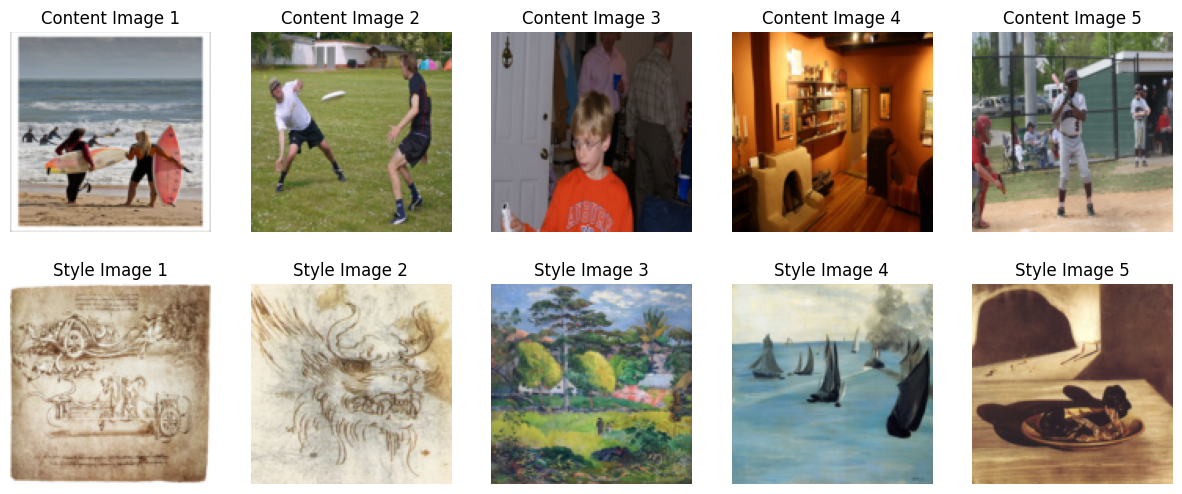

In [61]:
# display random images
display_random_images(combined_dataset, num_images=5)

# 2.0 Make Model

## 2.1 Encoder Model

In [23]:
class encoder4(nn.Module):
    def __init__(self):
        super(encoder4,self).__init__()
        # vgg
        # 224 x 224
        self.conv1 = nn.Conv2d(3,3,1,1,0)
        self.reflecPad1 = nn.ReflectionPad2d((1,1,1,1))
        # 226 x 226

        self.conv2 = nn.Conv2d(3,64,3,1,0)
        self.relu2 = nn.ReLU(inplace=True)
        # 224 x 224

        self.reflecPad3 = nn.ReflectionPad2d((1,1,1,1))
        self.conv3 = nn.Conv2d(64,64,3,1,0)
        self.relu3 = nn.ReLU(inplace=True)
        # 224 x 224

        self.maxPool = nn.MaxPool2d(kernel_size=2,stride=2)
        # 112 x 112

        self.reflecPad4 = nn.ReflectionPad2d((1,1,1,1))
        self.conv4 = nn.Conv2d(64,128,3,1,0)
        self.relu4 = nn.ReLU(inplace=True)
        # 112 x 112

        self.reflecPad5 = nn.ReflectionPad2d((1,1,1,1))
        self.conv5 = nn.Conv2d(128,128,3,1,0)
        self.relu5 = nn.ReLU(inplace=True)
        # 112 x 112

        self.maxPool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        # 56 x 56

        self.reflecPad6 = nn.ReflectionPad2d((1,1,1,1))
        self.conv6 = nn.Conv2d(128,256,3,1,0)
        self.relu6 = nn.ReLU(inplace=True)
        # 56 x 56

        self.reflecPad7 = nn.ReflectionPad2d((1,1,1,1))
        self.conv7 = nn.Conv2d(256,256,3,1,0)
        self.relu7 = nn.ReLU(inplace=True)
        # 56 x 56

        self.reflecPad8 = nn.ReflectionPad2d((1,1,1,1))
        self.conv8 = nn.Conv2d(256,256,3,1,0)
        self.relu8 = nn.ReLU(inplace=True)
        # 56 x 56

        self.reflecPad9 = nn.ReflectionPad2d((1,1,1,1))
        self.conv9 = nn.Conv2d(256,256,3,1,0)
        self.relu9 = nn.ReLU(inplace=True)
        # 56 x 56

        self.maxPool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        # 28 x 28

        self.reflecPad10 = nn.ReflectionPad2d((1,1,1,1))
        self.conv10 = nn.Conv2d(256,512,3,1,0)
        self.relu10 = nn.ReLU(inplace=True)
        # 28 x 28
    def forward(self,x,sF=None,matrix11=None,matrix21=None,matrix31=None):
        output = {}
        out = self.conv1(x)
        out = self.reflecPad1(out)
        out = self.conv2(out)
        output['r11'] = self.relu2(out)
        out = self.reflecPad7(output['r11'])

        out = self.conv3(out)
        output['r12'] = self.relu3(out)

        output['p1'] = self.maxPool(output['r12'])
        out = self.reflecPad4(output['p1'])
        out = self.conv4(out)
        output['r21'] = self.relu4(out)
        out = self.reflecPad7(output['r21'])

        out = self.conv5(out)
        output['r22'] = self.relu5(out)

        output['p2'] = self.maxPool2(output['r22'])
        out = self.reflecPad6(output['p2'])
        out = self.conv6(out)
        output['r31'] = self.relu6(out)
        if(matrix31 is not None):
            feature3,transmatrix3 = matrix31(output['r31'],sF['r31'])
            out = self.reflecPad7(feature3)
        else:
            out = self.reflecPad7(output['r31'])
        out = self.conv7(out)
        output['r32'] = self.relu7(out)

        out = self.reflecPad8(output['r32'])
        out = self.conv8(out)
        output['r33'] = self.relu8(out)

        out = self.reflecPad9(output['r33'])
        out = self.conv9(out)
        output['r34'] = self.relu9(out)

        output['p3'] = self.maxPool3(output['r34'])
        out = self.reflecPad10(output['p3'])
        out = self.conv10(out)
        output['r41'] = self.relu10(out)

        return output

## 2.2 Decoder Model

In [24]:
class decoder4(nn.Module):
    def __init__(self):
        super(decoder4,self).__init__()
        # decoder
        self.reflecPad11 = nn.ReflectionPad2d((1,1,1,1))
        self.conv11 = nn.Conv2d(512,256,3,1,0)
        self.relu11 = nn.ReLU(inplace=True)
        # 28 x 28

        self.unpool = nn.UpsamplingNearest2d(scale_factor=2)
        # 56 x 56

        self.reflecPad12 = nn.ReflectionPad2d((1,1,1,1))
        self.conv12 = nn.Conv2d(256,256,3,1,0)
        self.relu12 = nn.ReLU(inplace=True)
        # 56 x 56

        self.reflecPad13 = nn.ReflectionPad2d((1,1,1,1))
        self.conv13 = nn.Conv2d(256,256,3,1,0)
        self.relu13 = nn.ReLU(inplace=True)
        # 56 x 56

        self.reflecPad14 = nn.ReflectionPad2d((1,1,1,1))
        self.conv14 = nn.Conv2d(256,256,3,1,0)
        self.relu14 = nn.ReLU(inplace=True)
        # 56 x 56

        self.reflecPad15 = nn.ReflectionPad2d((1,1,1,1))
        self.conv15 = nn.Conv2d(256,128,3,1,0)
        self.relu15 = nn.ReLU(inplace=True)
        # 56 x 56

        self.unpool2 = nn.UpsamplingNearest2d(scale_factor=2)
        # 112 x 112

        self.reflecPad16 = nn.ReflectionPad2d((1,1,1,1))
        self.conv16 = nn.Conv2d(128,128,3,1,0)
        self.relu16 = nn.ReLU(inplace=True)
        # 112 x 112

        self.reflecPad17 = nn.ReflectionPad2d((1,1,1,1))
        self.conv17 = nn.Conv2d(128,64,3,1,0)
        self.relu17 = nn.ReLU(inplace=True)
        # 112 x 112

        self.unpool3 = nn.UpsamplingNearest2d(scale_factor=2)
        # 224 x 224

        self.reflecPad18 = nn.ReflectionPad2d((1,1,1,1))
        self.conv18 = nn.Conv2d(64,64,3,1,0)
        self.relu18 = nn.ReLU(inplace=True)
        # 224 x 224

        self.reflecPad19 = nn.ReflectionPad2d((1,1,1,1))
        self.conv19 = nn.Conv2d(64,3,3,1,0)

    def forward(self,x):
        # decoder
        out = self.reflecPad11(x)
        out = self.conv11(out)
        out = self.relu11(out)
        out = self.unpool(out)
        out = self.reflecPad12(out)
        out = self.conv12(out)

        out = self.relu12(out)
        out = self.reflecPad13(out)
        out = self.conv13(out)
        out = self.relu13(out)
        out = self.reflecPad14(out)
        out = self.conv14(out)
        out = self.relu14(out)
        out = self.reflecPad15(out)
        out = self.conv15(out)
        out = self.relu15(out)
        out = self.unpool2(out)
        out = self.reflecPad16(out)
        out = self.conv16(out)
        out = self.relu16(out)
        out = self.reflecPad17(out)
        out = self.conv17(out)
        out = self.relu17(out)
        out = self.unpool3(out)
        out = self.reflecPad18(out)
        out = self.conv18(out)
        out = self.relu18(out)
        out = self.reflecPad19(out)
        out = self.conv19(out)
        return out

## 2.3 Transformation Model

1. Model consists of three main components: an encoder, a decoder, and a transformation module. 
2. **Encoder** : VGG-19 model pre-trained on the ImageNet dataset as the encoder. First few layer are used
3. **Decoder** : pre-trained symmetric network that reconstructs the stylized image from the encoded features. The decoder is trained on the MS-COCO dataset from scratch to reconstruct images.
4. **transformation module** : Learns the transformation matrix in a data-driven fashion. The transformation module consists of two convolutional neural networks (CNNs). Each CNN takes either content or style features as input and outputs a transformation matrix, respectively. These two transformation matrices are then multiplied to generate the final transformation matrix T. 
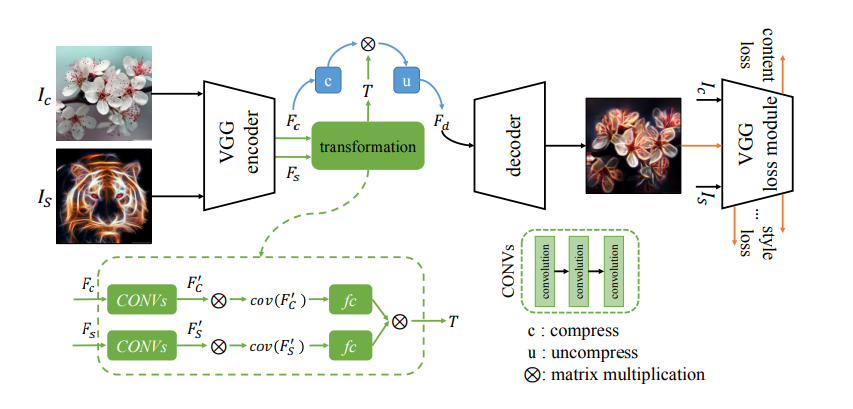

In [25]:
class CNN(nn.Module):
    def __init__(self,layer,matrixSize=32):
        super(CNN,self).__init__()
        if(layer == 'r31'):
            # 256x64x64
            self.convs = nn.Sequential(nn.Conv2d(256,128,3,1,1),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(128,64,3,1,1),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(64,matrixSize,3,1,1))
        elif(layer == 'r41'):
            # 512x32x32
            self.convs = nn.Sequential(nn.Conv2d(512,256,3,1,1),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(256,128,3,1,1),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(128,matrixSize,3,1,1))

        # 32x8x8
        self.fc = nn.Linear(matrixSize*matrixSize,matrixSize*matrixSize)
        #self.fc = nn.Linear(32*64,256*256)

    def forward(self,x):
        out = self.convs(x)
        # 32x8x8
        b,c,h,w = out.size()
        out = out.view(b,c,-1)
        # 32x64
        out = torch.bmm(out,out.transpose(1,2)).div(h*w)
        # 32x32
        out = out.view(out.size(0),-1)
        return self.fc(out)

class MulLayer(nn.Module):
    def __init__(self,layer,matrixSize=32):
        super(MulLayer,self).__init__()
        self.snet = CNN(layer,matrixSize)
        self.cnet = CNN(layer,matrixSize)
        self.matrixSize = matrixSize

        if(layer == 'r41'):
            self.compress = nn.Conv2d(512,matrixSize,1,1,0)
            self.unzip = nn.Conv2d(matrixSize,512,1,1,0)
        elif(layer == 'r31'):
            self.compress = nn.Conv2d(256,matrixSize,1,1,0)
            self.unzip = nn.Conv2d(matrixSize,256,1,1,0)
        self.transmatrix = None

    def forward(self,cF,sF,trans=True):
        cFBK = cF.clone()
        cb,cc,ch,cw = cF.size()
        cFF = cF.view(cb,cc,-1)
        cMean = torch.mean(cFF,dim=2,keepdim=True)
        cMean = cMean.unsqueeze(3)
        cMean = cMean.expand_as(cF)
        cF = cF - cMean

        sb,sc,sh,sw = sF.size()
        sFF = sF.view(sb,sc,-1)
        sMean = torch.mean(sFF,dim=2,keepdim=True)
        sMean = sMean.unsqueeze(3)
        sMeanC = sMean.expand_as(cF)
        sMeanS = sMean.expand_as(sF)
        sF = sF - sMeanS


        compress_content = self.compress(cF)
        b,c,h,w = compress_content.size()
        compress_content = compress_content.view(b,c,-1)

        if(trans):
            cMatrix = self.cnet(cF)
            sMatrix = self.snet(sF)

            sMatrix = sMatrix.view(sMatrix.size(0),self.matrixSize,self.matrixSize)
            cMatrix = cMatrix.view(cMatrix.size(0),self.matrixSize,self.matrixSize)
            transmatrix = torch.bmm(sMatrix,cMatrix)
            transfeature = torch.bmm(transmatrix,compress_content).view(b,c,h,w)
            out = self.unzip(transfeature.view(b,c,h,w))
            out = out + sMeanC
            return out, transmatrix
        else:
            out = self.unzip(compress_content.view(b,c,h,w))
            out = out + cMean
            return out

## 2.4 Style Tranfer Model

In [26]:
class ArtStylerNet(nn.Module):
    def __init__(self, encoder, decoder, transform_model):
        super(ArtStylerNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transform_model = transform_model
        
        # freaze encode and decoder only tranformation model 
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
            
    def forward(self, content_image, style_image):
        # Encode the input image
        content_feature = self.encoder(content_image)
        style_feature = self.encoder(style_image)

        #  Combiene Content and style features
        feature, transmatrix = self.transform_model(content_feature['r41'], content_feature['r41'])

        # Decode the transformed image
        decoded_image = self.decoder(feature)

        if self.training:
            tF = self.encoder(decoded_image)
            return decoded_image, [tF, style_feature, content_feature]
        else:
            return decoded_image

### load weights and create model

In [27]:
encoder = encoder4()
decoder = decoder4()
transform_model = MulLayer('r41')

encoder.load_state_dict(torch.load(ENCODER_PATH))
decoder.load_state_dict(torch.load(DECODER_PATH))

model = ArtStylerNet(encoder, decoder, transform_model)

# 3.0 Make Loss Funtion, And Optimizer

In [28]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## 3.1 Loss Funtion

### The style Loss
Given an input feature maps from multiple layers content layers **L**, the style loss is defined as the Sum of 1. Mean Squared Error between the mean feature map **sF** of our style image **S** and the mean feature map **tF** of our generated image **T**. and 2. Mean Squared Error between the GramMatrix of feature map **sF** of our style image **S** and the  feature map **tF** of our generated image **T**.

#### $$ StyletLoss = \sum_{i=0}^{L} \left[MSE(mean(sF_i), mean(tF_i)) + MSE(G(sF_i), G(tF_i))\right] $$

### GramMatrix

### $$ G_{i,j} = \frac{1}{C \times H \times W}  \sum_{k=0}^{C} F_{i,k} \times F_{j,k}$$

Where:  
1. $ G_{i,j} $ is an element of the Gram matrix.
2. $ F_{i,k} $ is the k-th element of the flattened feature matrix F derived from the input tensor.

In [29]:
class styleLoss(nn.Module):
    def forward(self,input,target):
        ib,ic,ih,iw = input.size()
        iF = input.view(ib,ic,-1)
        iMean = torch.mean(iF,dim=2)
        iCov = GramMatrix()(input)

        tb,tc,th,tw = target.size()
        tF = target.view(tb,tc,-1)
        tMean = torch.mean(tF,dim=2)
        tCov = GramMatrix()(target)

        loss = nn.MSELoss(size_average=False)(iMean,tMean) + nn.MSELoss(size_average=False)(iCov,tCov)
        return loss/tb

class GramMatrix(nn.Module):
    def forward(self,input):
        b, c, h, w = input.size()
        f = input.view(b,c,h*w) # bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)   #
        # batch1: bxmxp, batch2: bxpxn -> bxmxn #
        G = torch.bmm(f,f.transpose(1,2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(c*h*w)

### The content Loss
Given an input feature maps from multiple layers content layers **L**, the content loss is defined as the Mean Squared Error between the feature map **cF** of our content image **C** and the feature map **tF** of our generated image **T**.

### $$ ContentLoss = \sum_{i=0}^{L} MSE(cF_i, tF_i) $$

### Total Loss
Loss is weighted sum of content and style loss, $\alpha$ and $\beta$ are weights for content loss and style loss. We have set  $\alpha$ and $\beta$ to 1.0 and 0.02 respectively

### $$ Loss = \alpha ContentLoss + \beta StyleLoss $$


In [30]:
class LossCriterion(nn.Module):
    def __init__(self,style_layers,content_layers,style_weight,content_weight):
        super(LossCriterion,self).__init__()

        self.style_layers = style_layers
        self.content_layers = content_layers
        self.style_weight = style_weight
        self.content_weight = content_weight

        self.styleLosses = [styleLoss()] * len(style_layers)
        self.contentLosses = [nn.MSELoss()] * len(content_layers)

    def forward(self,tF,sF,cF):
        # content loss
        totalContentLoss = 0
        for i,layer in enumerate(self.content_layers):
            cf_i = cF[layer]
            cf_i = cf_i.detach()
            tf_i = tF[layer]
            loss_i = self.contentLosses[i]
            totalContentLoss += loss_i(tf_i,cf_i)
        totalContentLoss = totalContentLoss * self.content_weight

        # style loss
        totalStyleLoss = 0
        for i,layer in enumerate(self.style_layers):
            sf_i = sF[layer]
            sf_i = sf_i.detach()
            tf_i = tF[layer]
            loss_i = self.styleLosses[i]
            totalStyleLoss += loss_i(tf_i,sf_i)
        totalStyleLoss = totalStyleLoss * self.style_weight
        loss = totalStyleLoss + totalContentLoss

        return loss,totalStyleLoss,totalContentLoss

In [31]:
# making the loss
STYLE_LAYERS = ['r11', 'r21', 'r31', 'r41'] # layers feature used in loss calculation
CONTENT_LAYERS = ['r41'] # layer from which final outut is made

criterion = LossCriterion(STYLE_LAYERS, CONTENT_LAYERS, STYLE_WEIGHT, CONTENT_WEIGHT)

## 3.2 Optimizer

In [32]:
optimizer = optim.Adam(model.parameters(), learning_rate)

## 3.3 LR schular

In [33]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

# 4.0 Model Training

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, test_loader, num_epochs, optimizer, scheduler, criterion):
    model.to(device)
    train_losses = []
    test_losses = []

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        running_sloss = 0.0
        running_closs = 0.0

        # Training
        model.train()
        with tqdm(train_loader, desc=f'Train :: Epoch : {epoch}/{num_epochs}') as tqdm_loader:
            for i, (content_image, style_image) in enumerate(tqdm_loader):
                content_image, style_image = content_image.to(device), style_image.to(device)
                optimizer.zero_grad()
                # Forward pass
                outputs, features = model(content_image, style_image)
                loss, sloss, closs = criterion(features[0], features[1], features[2])
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                # Update running losses
                running_loss += loss.item()
                running_sloss += sloss.item()
                running_closs += closs.item()

                # Update tqdm description
                tqdm_loader.set_postfix(
                    loss=running_loss / (i + 1),
                    style_loss=running_sloss / (i + 1),
                    content_loss=running_closs / (i + 1)
                )

        

        # Calculate average losses for the epoch
        avg_loss = running_loss / len(train_loader)
        avg_sloss = running_sloss / len(train_loader)
        avg_closs = running_closs / len(train_loader)

        # Store average losses
        train_losses.append((avg_loss, avg_sloss, avg_closs))

        # Evaluation
        if epoch % eval_freq == 0:
            running_loss = 0.0
            running_sloss = 0.0
            running_closs = 0.0
#             model.eval()
            with torch.no_grad():
                for i, (content_image, style_image) in enumerate(test_loader):
#                     if i ==10: break 
                    content_image, style_image = content_image.to(device), style_image.to(device)

                    # Forward pass
                    outputs, features = model(content_image, style_image)
                    loss, sloss, closs = criterion(features[0], features[1], features[2])

                    # Update running losses
                    running_loss += loss.item()
                    running_sloss += sloss.item()
                    running_closs += closs.item()

            # Save model weights on the CPU
            model.to('cpu')
            final_weights_path = f'model_weights_e{epoch}.pth'
            final_weights_path = f'model_weights.pth'

            torch.save(model.state_dict(), final_weights_path)
            model.to(device)

            avg_loss = running_loss / len(test_loader)
            avg_sloss = running_sloss / len(test_loader)
            avg_closs = running_closs / len(test_loader)
            print(f"Test loss : {(avg_loss, avg_sloss, avg_closs)}")
            test_losses.append((avg_loss, avg_sloss, avg_closs))
        # Update the learning rate scheduler
        scheduler.step(avg_loss)

    return model, train_losses, test_losses


In [24]:
model, train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, optimizer, scheduler, criterion)

Train :: Epoch : 1/120:   0%|          | 0/1407 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.

  warnings.warn(warning.format(ret))

Train :: Epoch : 1/120: 100%|██████████| 1407/1407 [03:53<00:00,  6.02it/s, content_loss=2.48, loss=13.8, style_loss=11.3]


Test loss : (11.53782844543457, 9.457408920215194, 2.0804195214229027)


Train :: Epoch : 2/120: 100%|██████████| 1407/1407 [03:17<00:00,  7.11it/s, content_loss=1.98, loss=11.3, style_loss=9.28]


Test loss : (11.009346093341803, 9.140782137585294, 1.8685639193103571)


Train :: Epoch : 3/120: 100%|██████████| 1407/1407 [03:16<00:00,  7.15it/s, content_loss=1.79, loss=10.8, style_loss=8.98]


Test loss : (10.751611156828085, 9.059123330814824, 1.6924878252539666)


Train :: Epoch : 4/120: 100%|██████████| 1407/1407 [03:17<00:00,  7.14it/s, content_loss=1.7, loss=10.5, style_loss=8.84]


Test loss : (10.729128357711112, 9.110314925005481, 1.618813452447296)


Train :: Epoch : 5/120: 100%|██████████| 1407/1407 [03:18<00:00,  7.10it/s, content_loss=1.65, loss=10.3, style_loss=8.69]


Test loss : (10.60069250604909, 9.055096747768912, 1.5455957476500493)


Train :: Epoch : 6/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.06it/s, content_loss=1.61, loss=10.2, style_loss=8.57]


Test loss : (10.507601261138916, 8.923055156780656, 1.5845461423230018)


Train :: Epoch : 7/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.05it/s, content_loss=1.59, loss=9.99, style_loss=8.4]


Test loss : (10.61840595561228, 9.115009520463882, 1.503396435907692)


Train :: Epoch : 8/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.05it/s, content_loss=1.59, loss=9.77, style_loss=8.18]


Test loss : (10.830890679815013, 9.223724283230533, 1.607166385195058)


Train :: Epoch : 9/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.00it/s, content_loss=1.59, loss=9.54, style_loss=7.95]


Test loss : (10.661789556977096, 9.18629040383989, 1.4754991728788729)


Train :: Epoch : 10/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.04it/s, content_loss=1.6, loss=9.28, style_loss=7.68]


Test loss : (10.725643164033343, 9.200174589825284, 1.5254685339654328)


Train :: Epoch : 11/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.02it/s, content_loss=1.61, loss=9.09, style_loss=7.48]


Test loss : (10.825572785298537, 9.31033707272475, 1.5152356867577619)


Train :: Epoch : 12/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.00it/s, content_loss=1.62, loss=8.81, style_loss=7.18]


Test loss : (11.325407823939232, 9.625736479546614, 1.699671342114734)


Train :: Epoch : 13/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.94it/s, content_loss=1.63, loss=8.68, style_loss=7.05]


Test loss : (11.200096051404431, 9.542627307260112, 1.6574687578116254)


Train :: Epoch : 14/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.95it/s, content_loss=1.64, loss=8.38, style_loss=6.74]


Test loss : (10.998857270380494, 9.405303718178136, 1.5935535689068447)


Train :: Epoch : 15/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.93it/s, content_loss=1.65, loss=8.17, style_loss=6.52]


Test loss : (11.191730362594507, 9.614988888904547, 1.5767414752085498)


Train :: Epoch : 16/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.95it/s, content_loss=1.66, loss=7.91, style_loss=6.25]


Test loss : (11.398933137298389, 9.857704918855315, 1.5412282351475612)


Train :: Epoch : 17/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.92it/s, content_loss=1.68, loss=7.69, style_loss=6.01]


Test loss : (11.289807842035962, 9.717136741443804, 1.5726711066665164)

Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.


Train :: Epoch : 18/120: 100%|██████████| 1407/1407 [03:25<00:00,  6.86it/s, content_loss=1.7, loss=7.11, style_loss=5.41]


Test loss : (11.314705708983597, 9.762573175369555, 1.5521325609486574)


Train :: Epoch : 19/120: 100%|██████████| 1407/1407 [03:24<00:00,  6.90it/s, content_loss=1.73, loss=6.78, style_loss=5.05]


Test loss : (11.45673464513888, 9.879138345171691, 1.5775963143937906)


Train :: Epoch : 20/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.98it/s, content_loss=1.75, loss=6.59, style_loss=4.84]


Test loss : (11.584799456748234, 9.998689253618762, 1.5861101750355617)


Train :: Epoch : 21/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.98it/s, content_loss=1.76, loss=6.4, style_loss=4.64]


Test loss : (11.697419938008498, 10.048723943673881, 1.6486960064833331)


Train :: Epoch : 22/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.98it/s, content_loss=1.77, loss=6.22, style_loss=4.45]


Test loss : (11.704298760480942, 10.129257955368917, 1.5750407891668332)


Train :: Epoch : 23/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.78, loss=6.06, style_loss=4.27]


Test loss : (11.876322011279452, 10.2302979633307, 1.6460240433929831)


Train :: Epoch : 24/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.93it/s, content_loss=1.79, loss=6.1, style_loss=4.31]


Test loss : (12.006672057376546, 10.339833915613259, 1.6668381592270676)


Train :: Epoch : 25/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.78, loss=6.11, style_loss=4.34]


Test loss : (11.906635017152045, 10.295648987885494, 1.610986046730333)


Train :: Epoch : 26/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.94it/s, content_loss=1.81, loss=5.7, style_loss=3.89]


Test loss : (12.020307583414066, 10.370954452806219, 1.6493531268113737)


Train :: Epoch : 27/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.96it/s, content_loss=1.82, loss=5.57, style_loss=3.75]


Test loss : (12.009718724876452, 10.412948893893297, 1.5967698294645662)


Train :: Epoch : 28/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.93it/s, content_loss=1.83, loss=5.49, style_loss=3.67]


Test loss : (12.211918733681843, 10.561740753756967, 1.6501779647389794)

Epoch 00028: reducing learning rate of group 0 to 2.5000e-05.


Train :: Epoch : 29/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.92it/s, content_loss=1.83, loss=5.31, style_loss=3.48]


Test loss : (12.143242222488306, 10.503660499669945, 1.639581747875092)


Train :: Epoch : 30/120: 100%|██████████| 1407/1407 [03:24<00:00,  6.89it/s, content_loss=1.85, loss=5.12, style_loss=3.28]


Test loss : (12.31905727629449, 10.635276393525919, 1.683780878972096)


Train :: Epoch : 31/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.98it/s, content_loss=1.86, loss=4.99, style_loss=3.14]


Test loss : (12.282518708781831, 10.619000978530591, 1.6635177423999568)


Train :: Epoch : 32/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.02it/s, content_loss=1.86, loss=4.94, style_loss=3.08]


Test loss : (12.421885223145697, 10.740416204853423, 1.6814689947541352)


Train :: Epoch : 33/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.98it/s, content_loss=1.87, loss=4.89, style_loss=3.02]


Test loss : (12.568428440458456, 10.88025347594243, 1.6881749455336552)


Train :: Epoch : 34/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.00it/s, content_loss=1.87, loss=4.83, style_loss=2.96]


Test loss : (12.523265316228198, 10.835925026304404, 1.6873402777750781)


Train :: Epoch : 35/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.92it/s, content_loss=1.88, loss=4.78, style_loss=2.9]


Test loss : (12.6382955441809, 10.939253564093523, 1.6990419914768)


Train :: Epoch : 36/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.99it/s, content_loss=1.88, loss=4.71, style_loss=2.83]


Test loss : (12.77113731651549, 11.036699313267022, 1.7344379986927008)


Train :: Epoch : 37/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.94it/s, content_loss=1.89, loss=4.67, style_loss=2.78]


Test loss : (12.63281287661024, 10.932580577340095, 1.700232308381682)


Train :: Epoch : 38/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.90it/s, content_loss=1.89, loss=4.62, style_loss=2.73]


Test loss : (12.688778057219876, 10.978405909933102, 1.7103721472867734)


Train :: Epoch : 39/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.99it/s, content_loss=1.89, loss=4.58, style_loss=2.68]


Test loss : (12.678009689233864, 10.985047194608457, 1.6929625234786112)

Epoch 00039: reducing learning rate of group 0 to 1.2500e-05.


Train :: Epoch : 40/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.97it/s, content_loss=1.9, loss=4.46, style_loss=2.56]


Test loss : (12.849717085528525, 11.12529065502677, 1.7244264411318833)


Train :: Epoch : 41/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.96it/s, content_loss=1.91, loss=4.38, style_loss=2.47]


Test loss : (12.827194687667166, 11.104226935441327, 1.7229677833569277)


Train :: Epoch : 42/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.03it/s, content_loss=1.91, loss=4.35, style_loss=2.44]


Test loss : (12.87421211315568, 11.14428987320821, 1.729922234632407)


Train :: Epoch : 43/120: 100%|██████████| 1407/1407 [03:24<00:00,  6.89it/s, content_loss=1.91, loss=4.33, style_loss=2.42]


Test loss : (12.859386923966134, 11.128130463278218, 1.7312564811888773)


Train :: Epoch : 44/120: 100%|██████████| 1407/1407 [03:21<00:00,  7.00it/s, content_loss=1.91, loss=4.3, style_loss=2.39]


Test loss : (12.904803014864587, 11.179974823241022, 1.724828215921001)


Train :: Epoch : 45/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.05it/s, content_loss=1.92, loss=4.28, style_loss=2.36]


Test loss : (13.02449177177089, 11.283055123250197, 1.7414366006851196)


Train :: Epoch : 46/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.95it/s, content_loss=1.92, loss=4.25, style_loss=2.33]


Test loss : (12.968503229177681, 11.232267082117165, 1.7362361387082725)


Train :: Epoch : 47/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.02it/s, content_loss=1.92, loss=4.23, style_loss=2.31]


Test loss : (13.035268376587302, 11.279053706272393, 1.7562147189097799)


Train :: Epoch : 48/120: 100%|██████████| 1407/1407 [03:25<00:00,  6.84it/s, content_loss=1.92, loss=4.21, style_loss=2.28]


Test loss : (13.038802116539827, 11.290925159575833, 1.7478769767056606)


Train :: Epoch : 49/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.02it/s, content_loss=1.92, loss=4.18, style_loss=2.26]


Test loss : (13.123072618132184, 11.372212974888503, 1.7508596462808597)


Train :: Epoch : 50/120: 100%|██████████| 1407/1407 [03:17<00:00,  7.11it/s, content_loss=1.93, loss=4.17, style_loss=2.24]


Test loss : (13.175652260992937, 11.405432767928785, 1.7702194831933185)

Epoch 00050: reducing learning rate of group 0 to 6.2500e-06.


Train :: Epoch : 51/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.97it/s, content_loss=1.93, loss=4.11, style_loss=2.18]


Test loss : (13.143480367721265, 11.37888919927512, 1.7645911692054408)


Train :: Epoch : 52/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.06it/s, content_loss=1.93, loss=4.09, style_loss=2.15]


Test loss : (13.165688077355647, 11.411071813789903, 1.754616243824078)


Train :: Epoch : 53/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.92it/s, content_loss=1.93, loss=4.07, style_loss=2.14]


Test loss : (13.149770779214847, 11.39693729740799, 1.752833483325448)


Train :: Epoch : 54/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.06it/s, content_loss=1.93, loss=4.06, style_loss=2.13]


Test loss : (13.220063173087539, 11.453065550251372, 1.766997587908605)


Train :: Epoch : 55/120: 100%|██████████| 1407/1407 [03:18<00:00,  7.08it/s, content_loss=1.93, loss=4.05, style_loss=2.12]


Test loss : (13.223313143298885, 11.45065342848468, 1.7726596905167695)


Train :: Epoch : 56/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.93it/s, content_loss=1.93, loss=4.04, style_loss=2.1]


Test loss : (13.249994362995123, 11.47838352592128, 1.7716108256844199)


Train :: Epoch : 57/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.06it/s, content_loss=1.94, loss=4.03, style_loss=2.09]


Test loss : (13.26589219281628, 11.494443583640324, 1.7714486053794811)


Train :: Epoch : 58/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.92it/s, content_loss=1.94, loss=4.02, style_loss=2.08]


Test loss : (13.27163427194972, 11.49877990431087, 1.7728543668795542)


Train :: Epoch : 59/120: 100%|██████████| 1407/1407 [03:18<00:00,  7.09it/s, content_loss=1.94, loss=4, style_loss=2.07]


Test loss : (13.293192693382311, 11.51392866243982, 1.7792640689072337)


Train :: Epoch : 60/120: 100%|██████████| 1407/1407 [03:24<00:00,  6.87it/s, content_loss=1.94, loss=3.99, style_loss=2.06]


Test loss : (13.287222746830837, 11.511745756598794, 1.7754769720089663)


Train :: Epoch : 61/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.06it/s, content_loss=1.94, loss=3.98, style_loss=2.05]


Test loss : (13.287855020753897, 11.50717498390538, 1.7806800330520436)

Epoch 00061: reducing learning rate of group 0 to 3.1250e-06.


Train :: Epoch : 62/120: 100%|██████████| 1407/1407 [03:24<00:00,  6.89it/s, content_loss=1.94, loss=3.96, style_loss=2.02]


Test loss : (13.316554045221608, 11.538191534151697, 1.7783625201814492)


Train :: Epoch : 63/120: 100%|██████████| 1407/1407 [03:18<00:00,  7.10it/s, content_loss=1.94, loss=3.95, style_loss=2.01]


Test loss : (13.298808195029094, 11.522980343763995, 1.7758278095038833)


Train :: Epoch : 64/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.94, loss=3.94, style_loss=2]


Test loss : (13.365913737351727, 11.581505483882442, 1.7844083020641546)


Train :: Epoch : 65/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.06it/s, content_loss=1.94, loss=3.94, style_loss=2]


Test loss : (13.343823189948015, 11.558610053578759, 1.785213143962204)


Train :: Epoch : 66/120: 100%|██████████| 1407/1407 [03:25<00:00,  6.84it/s, content_loss=1.94, loss=3.93, style_loss=1.99]


Test loss : (13.375301342860908, 11.58822311109798, 1.7870782089840835)


Train :: Epoch : 67/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.05it/s, content_loss=1.94, loss=3.93, style_loss=1.98]


Test loss : (13.346531716121989, 11.567922173032336, 1.7786095506826025)


Train :: Epoch : 68/120: 100%|██████████| 1407/1407 [03:25<00:00,  6.85it/s, content_loss=1.94, loss=3.92, style_loss=1.98]


Test loss : (13.38329165148887, 11.599188719585444, 1.784102950885797)


Train :: Epoch : 69/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.03it/s, content_loss=1.94, loss=3.92, style_loss=1.97]


Test loss : (13.354752400878128, 11.575719462838142, 1.7790329220947947)


Train :: Epoch : 70/120: 100%|██████████| 1407/1407 [03:26<00:00,  6.80it/s, content_loss=1.94, loss=3.91, style_loss=1.97]


Test loss : (13.39476836259198, 11.608788733269758, 1.7859796217292736)


Train :: Epoch : 71/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.01it/s, content_loss=1.95, loss=3.91, style_loss=1.96]


Test loss : (13.401214131883755, 11.613363490742483, 1.787850669235181)


Train :: Epoch : 72/120: 100%|██████████| 1407/1407 [03:26<00:00,  6.82it/s, content_loss=1.95, loss=3.9, style_loss=1.96]


Test loss : (13.388418628911303, 11.601769981870227, 1.7866486250215274)

Epoch 00072: reducing learning rate of group 0 to 1.5625e-06.


Train :: Epoch : 73/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.00it/s, content_loss=1.95, loss=3.89, style_loss=1.94]


Test loss : (13.42255192045953, 11.632459895625995, 1.7900920339450714)


Train :: Epoch : 74/120: 100%|██████████| 1407/1407 [03:27<00:00,  6.79it/s, content_loss=1.95, loss=3.89, style_loss=1.94]


Test loss : (13.433218220996249, 11.642732407636704, 1.7904858156374306)


Train :: Epoch : 75/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.03it/s, content_loss=1.95, loss=3.88, style_loss=1.94]


Test loss : (13.415021039877727, 11.625108573087461, 1.7899124569194331)


Train :: Epoch : 76/120: 100%|██████████| 1407/1407 [03:26<00:00,  6.80it/s, content_loss=1.95, loss=3.88, style_loss=1.93]


Test loss : (13.41752975002216, 11.627770448186595, 1.7897592950019108)


Train :: Epoch : 77/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.05it/s, content_loss=1.95, loss=3.88, style_loss=1.93]


Test loss : (13.431145868483622, 11.638956883910355, 1.7921890012777535)


Train :: Epoch : 78/120: 100%|██████████| 1407/1407 [03:25<00:00,  6.85it/s, content_loss=1.95, loss=3.87, style_loss=1.93]


Test loss : (13.434266545969969, 11.641032164263876, 1.7932343930955146)


Train :: Epoch : 79/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.99it/s, content_loss=1.95, loss=3.87, style_loss=1.92]


Test loss : (13.444238201068465, 11.652580309825339, 1.7916578563155643)


Train :: Epoch : 80/120: 100%|██████████| 1407/1407 [03:21<00:00,  7.00it/s, content_loss=1.95, loss=3.87, style_loss=1.92]


Test loss : (13.45704909646587, 11.66287866215797, 1.7941704555681557)


Train :: Epoch : 81/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.03it/s, content_loss=1.95, loss=3.87, style_loss=1.92]


Test loss : (13.439998395883354, 11.650979928909594, 1.7890184730481191)


Train :: Epoch : 82/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.01it/s, content_loss=1.95, loss=3.86, style_loss=1.92]


Test loss : (13.463703769027807, 11.67011252482226, 1.793591275336636)


Train :: Epoch : 83/120: 100%|██████████| 1407/1407 [03:21<00:00,  7.00it/s, content_loss=1.95, loss=3.86, style_loss=1.91]


Test loss : (13.43055032620764, 11.640845104387612, 1.7897051944854154)

Epoch 00083: reducing learning rate of group 0 to 7.8125e-07.


Train :: Epoch : 84/120: 100%|██████████| 1407/1407 [03:16<00:00,  7.16it/s, content_loss=1.95, loss=3.86, style_loss=1.91]


Test loss : (13.45272098832829, 11.658583410226615, 1.794137556841419)


Train :: Epoch : 85/120: 100%|██████████| 1407/1407 [03:20<00:00,  7.01it/s, content_loss=1.95, loss=3.85, style_loss=1.9]


Test loss : (13.459064611204111, 11.66462985117724, 1.7944347144691808)


Train :: Epoch : 86/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.97it/s, content_loss=1.95, loss=3.85, style_loss=1.9]


Test loss : (13.466457937933077, 11.67066900897178, 1.7957889524994382)


Train :: Epoch : 87/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.97it/s, content_loss=1.95, loss=3.85, style_loss=1.9]


Test loss : (13.48346739362, 11.686040046108756, 1.7974273748458571)


Train :: Epoch : 88/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.94it/s, content_loss=1.95, loss=3.85, style_loss=1.9]


Test loss : (13.473612888603453, 11.676507980200896, 1.797104876512175)


Train :: Epoch : 89/120: 100%|██████████| 1407/1407 [03:17<00:00,  7.14it/s, content_loss=1.95, loss=3.85, style_loss=1.9]


Test loss : (13.473152646593228, 11.676177589756668, 1.7969750074823951)


Train :: Epoch : 90/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.97it/s, content_loss=1.95, loss=3.85, style_loss=1.9]


Test loss : (13.48339464102581, 11.687412073657772, 1.7959826068513711)


Train :: Epoch : 91/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.97it/s, content_loss=1.95, loss=3.85, style_loss=1.9]


Test loss : (13.478456843430829, 11.682377815246582, 1.7960790540002713)


Train :: Epoch : 92/120: 100%|██████████| 1407/1407 [03:21<00:00,  7.00it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.48656013513067, 11.689413429065874, 1.797146740233063)


Train :: Epoch : 93/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.94it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.482577949572521, 11.685228560380875, 1.7973493664128006)


Train :: Epoch : 94/120: 100%|██████████| 1407/1407 [03:15<00:00,  7.20it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.491968993168728, 11.692746812370933, 1.7992221671304884)

Epoch 00094: reducing learning rate of group 0 to 3.9063e-07.


Train :: Epoch : 95/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.95it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.487773445761128, 11.690721845930549, 1.797051594515515)


Train :: Epoch : 96/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.99it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.49642366056989, 11.69763352460922, 1.798790113181825)


Train :: Epoch : 97/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.97it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.488290598438045, 11.690964425445362, 1.7973261578067852)


Train :: Epoch : 98/120: 100%|██████████| 1407/1407 [03:21<00:00,  6.99it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.490274307834115, 11.692353843883344, 1.7979204328196823)


Train :: Epoch : 99/120: 100%|██████████| 1407/1407 [03:13<00:00,  7.25it/s, content_loss=1.95, loss=3.84, style_loss=1.89]


Test loss : (13.491262848969479, 11.692831409964592, 1.7984314503943084)


Train :: Epoch : 100/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.93it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.49980771010089, 11.699069290404108, 1.800738399195823)


Train :: Epoch : 101/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.491915994389043, 11.694068155470926, 1.797847833603051)


Train :: Epoch : 102/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.49766900129379, 11.698988294905158, 1.7986807185373488)


Train :: Epoch : 103/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.487478766471718, 11.689658547662626, 1.7978202605703075)


Train :: Epoch : 104/120: 100%|██████████| 1407/1407 [03:15<00:00,  7.21it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.498867763835154, 11.701010278835419, 1.7978575191680033)


Train :: Epoch : 105/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.49993245313122, 11.700988927464577, 1.798943515036516)

Epoch 00105: reducing learning rate of group 0 to 1.9531e-07.


Train :: Epoch : 106/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.92it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.502694427587425, 11.702803131881033, 1.799891266093892)


Train :: Epoch : 107/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.93it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.500516454125666, 11.701241183432805, 1.7992752547476702)


Train :: Epoch : 108/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.90it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.498072593834749, 11.699601264516259, 1.7984713323556694)


Train :: Epoch : 109/120: 100%|██████████| 1407/1407 [03:15<00:00,  7.20it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.502912393800772, 11.7030747832766, 1.799837574837314)


Train :: Epoch : 110/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.92it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.495751957984487, 11.697766091413559, 1.7979858673302231)


Train :: Epoch : 111/120: 100%|██████████| 1407/1407 [03:23<00:00,  6.91it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.49947349888504, 11.700812418749377, 1.798661067227649)


Train :: Epoch : 112/120: 100%|██████████| 1407/1407 [03:27<00:00,  6.79it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.503205554500507, 11.703795736762368, 1.799409804070831)


Train :: Epoch : 113/120: 100%|██████████| 1407/1407 [03:24<00:00,  6.90it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.501655305267139, 11.702267774351084, 1.7993875051000316)


Train :: Epoch : 114/120: 100%|██████████| 1407/1407 [03:19<00:00,  7.06it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.508281774581617, 11.709009267721965, 1.7992725174897795)


Train :: Epoch : 115/120: 100%|██████████| 1407/1407 [03:27<00:00,  6.77it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.507236990959022, 11.707643156598328, 1.7995938108225538)


Train :: Epoch : 116/120: 100%|██████████| 1407/1407 [03:27<00:00,  6.78it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.507220061721316, 11.708119933012943, 1.7991000930215144)

Epoch 00116: reducing learning rate of group 0 to 9.7656e-08.


Train :: Epoch : 117/120: 100%|██████████| 1407/1407 [03:27<00:00,  6.78it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.507139825517205, 11.70722737889381, 1.7999124352339726)


Train :: Epoch : 118/120: 100%|██████████| 1407/1407 [03:22<00:00,  6.95it/s, content_loss=1.95, loss=3.83, style_loss=1.87]


Test loss : (13.50999997375877, 11.70974696214032, 1.8002529911174896)


Train :: Epoch : 119/120: 100%|██████████| 1407/1407 [03:16<00:00,  7.14it/s, content_loss=1.95, loss=3.83, style_loss=1.88]


Test loss : (13.508599712590502, 11.708319840157868, 1.8002798572467391)


Train :: Epoch : 120/120: 100%|██████████| 1407/1407 [03:26<00:00,  6.81it/s, content_loss=1.95, loss=3.82, style_loss=1.87]


Test loss : (13.506056421121974, 11.706378262513763, 1.7996781783498776)


# 5.0 Test and experiment

In [35]:
 model.load_state_dict(torch.load("/kaggle/input/style-transfer-project-data/model_weights.pth"), strict=False)

<All keys matched successfully>

# 5.1 **Display example from testing set**
This images are from testing set similar type of images are seen by model so it gives good results

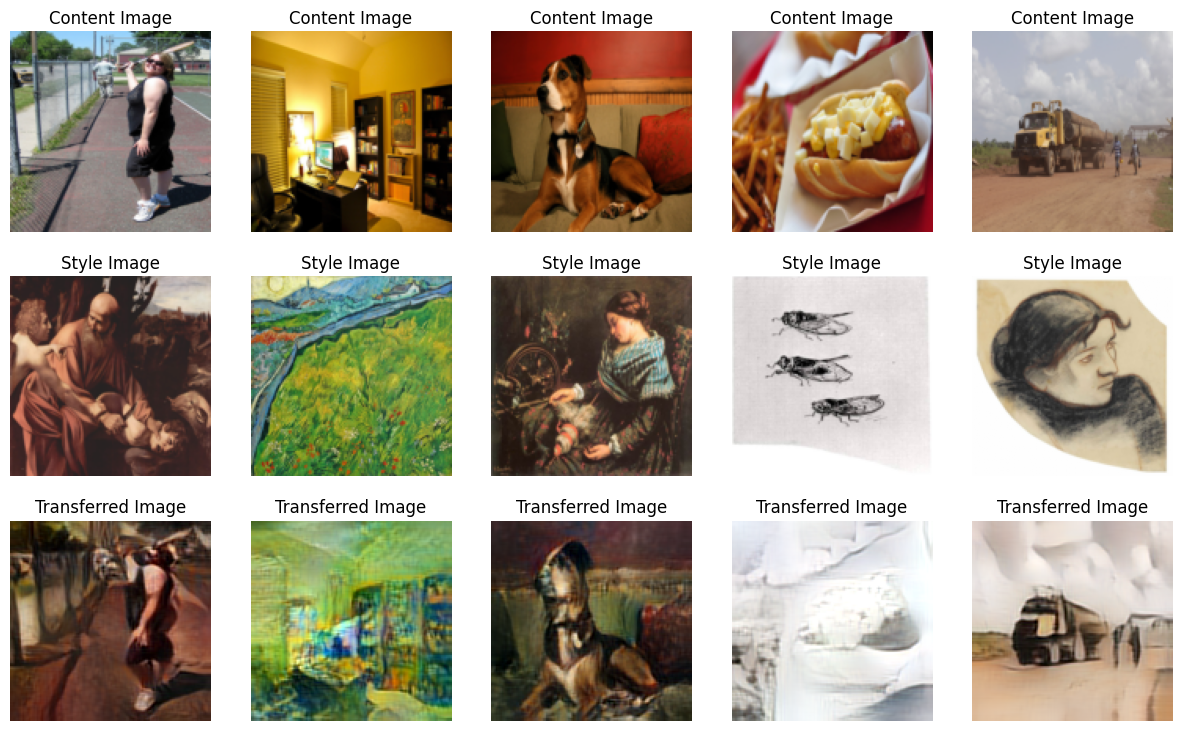

In [36]:
a, b = get(train_loader)
model.to(device)
model.eval()
y = model(a.to(device), b.to(device)) 
display_translated_images(a, b, y, num_images=5)

# 5.2 **Display example outside dataset**
As images are from outside the dataset model is not able to merge the style properly

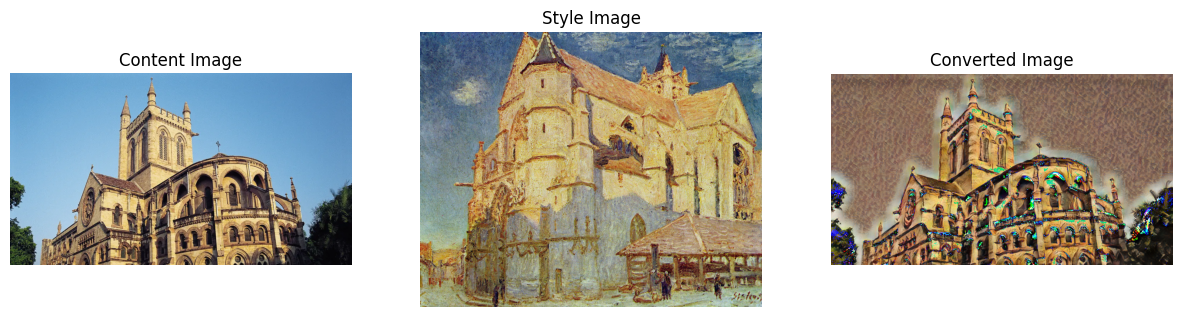

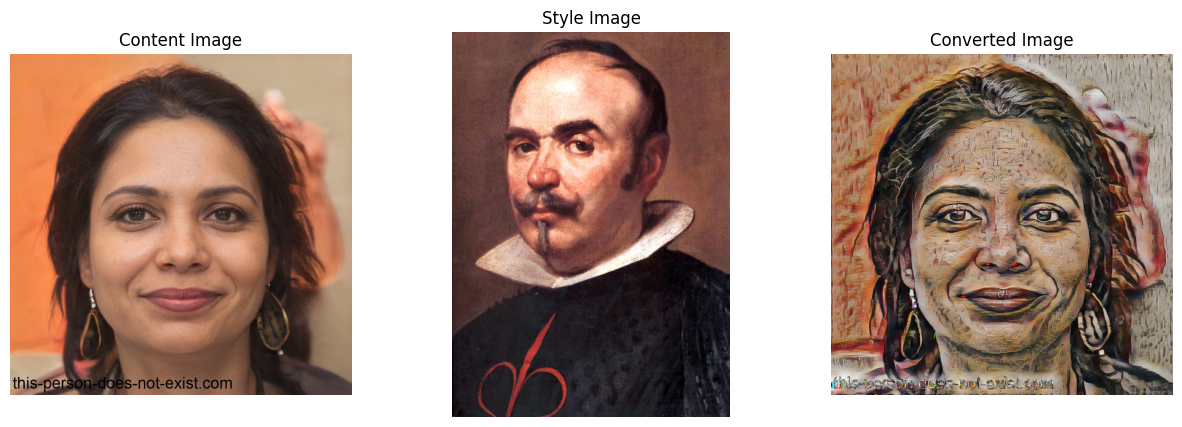

In [59]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import IPython.display as display



def convert_style(content_image_path, style_image_path, model):
    # Load images
    image1 = Image.open(content_image_path)
    image2 = Image.open(style_image_path)

    # Resize images to 256x256
#     resize = transforms.Resize((256, 256))
#     image1_resized = resize(image1)
#     image2_resized = resize(image2)
    image1_resized = image1
    image2_resized = image2

    # Convert images to PyTorch tensors
    to_tensor = transforms.ToTensor()
    image1_tensor = to_tensor(image1_resized).unsqueeze(0).to('cuda')
    image2_tensor = to_tensor(image2_resized).unsqueeze(0).to('cuda')

    model.eval()

    # Generate output from the model
    with torch.no_grad():
        output_tensor = model(image1_tensor, image2_tensor)
    
    output_tensor = denormalize_transform(output_tensor)
    
    
    # Convert tensors to PIL images
    output_image = transforms.ToPILImage()(output_tensor.squeeze(0).cpu())

    # Display images in a grid
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image1_resized)
    axes[0].axis('off')
    axes[0].set_title('Content Image')

    axes[1].imshow(image2_resized)
    axes[1].axis('off')
    axes[1].set_title('Style Image')

    axes[2].imshow(output_image)
    axes[2].axis('off')
    axes[2].set_title('Converted Image')

    plt.show()
    # Save the output image
    output_image.save("converted_image.jpg")
    return

content_image_path = "/kaggle/input/style-transfer-project-data/content.jpeg"
style_image_path = "/kaggle/input/style-transfer-project-data/style.jpg"

c = ["/kaggle/input/style-transfer-project-data/C1.jpg", "/kaggle/input/style-transfer-project-data/C2.jpeg"]
s = ["/kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley/Alfred_Sisley_118.jpg","/kaggle/input/best-artworks-of-all-time/images/images/Diego_Velazquez/Diego_Velazquez_122.jpg"]

for i in range(0, len(c)):
    convert_style(c[i], s[i], model)
    

**plot training loss**

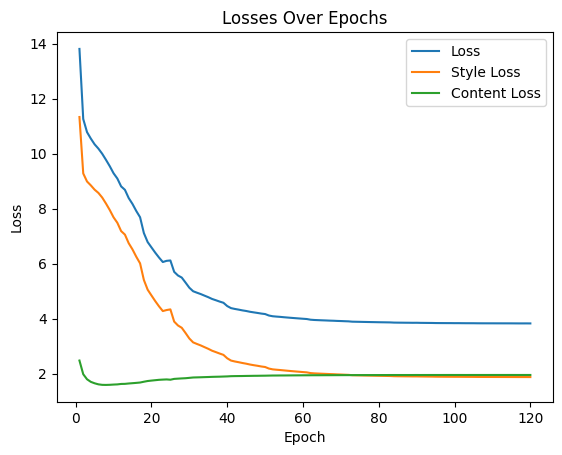

In [27]:
import matplotlib.pyplot as plt

loss_list = train_losses

# Extract individual losses
avg_losses, avg_slosses, avg_closses = zip(*loss_list)

# Plotting
epochs = range(1, len(loss_list) + 1)

plt.plot(epochs, avg_losses, label='Loss')
plt.plot(epochs, avg_slosses, label='Style Loss')
plt.plot(epochs, avg_closses, label='Content Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs')
plt.legend()
plt.show()


# 6.0 Limitations and Future Directions

1. As seen from the above example this method have limited to transferring styles that can be represented by the training data. Can be improved by using more diverse training dataset.
2. This method may not generalize well to unseen styles that are significantly different from the training data.
3. Can replace VGG19 model model that uses lightweight depth-wise convolutional neural network (CNN) model.  Models like MobileNetV2 or ShuffleNet offer improved speed and reduced memory footprint, thus optimizing the style transfer process. 